In [1]:
# Use RoBERTa Model for Sentiment Analysis and classification with the Rating converted into labels (postive, neutral, negative)

In [2]:
# Install Hugging Face Transformers and datasets
#!pip install transformers datasets

In [3]:
# Import Libraries
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
import os
os.environ["WANDB_DISABLED"] = "true"

2024-10-14 11:16:59.525450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:16:59.525504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:16:59.526676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 11:16:59.533434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 11:17:00.272006: W tensorflow/compiler/tf2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier      # NaiveBayes classifer for comparison with RoBERTa transformer model
import numpy as np
import re
import string
import nltk
%matplotlib inline

In [5]:
df = pd.read_csv(r"dataset/1429_1.csv")
df.head()

/tmp/ipykernel_208/1209413327.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"dataset/1429_1.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [6]:
df.shape

(34660, 21)

In [7]:
# Drop rows where Rating ('Reviews.rating') is missing - about 33 of them in the entire 30K dataset (less than .1%) 
df = df.dropna(subset=['reviews.rating'])
df.shape

(34627, 21)

In [8]:
# Add a 'label' column based on 'reviews.rating' which will indicate if it's positive or negative
def label_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply the function to create a new column
df['label'] = df['reviews.rating'].apply(label_sentiment)

# Drop rows where 'reviews.text' is missing (if any)
df = df.dropna(subset=['reviews.text'])

# Check the new DataFrame structure
print(df[['reviews.text', 'reviews.rating', 'label']].head())
print(df.shape)


                                        reviews.text  reviews.rating  label
0  This product so far has not disappointed. My c...             5.0      2
1  great for beginner or experienced person. Boug...             5.0      2
2  Inexpensive tablet for him to use and learn on...             5.0      2
3  I've had my Fire HD 8 two weeks now and I love...             4.0      2
4  I bought this for my grand daughter when she c...             5.0      2
(34626, 22)


In [9]:
# Split the dataset into Train and Validation set

train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviews.text'].tolist(), 
                                                                    df['label'].tolist(), 
                                                                    test_size=0.2, 
                                                                    random_state=42)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

Training set size: 27700
Validation set size: 6926


In [10]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [11]:
# Create PyTorch datasets from the tokenized ones above, so it can be used in the Model

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [12]:
# Load pre-trained RoBERTa model for classification, this needs to be trained with our Data

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # 3 labels (negative, neutral, positive)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Defining how the model will be trained - setting training arguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="steps",     # Evaluate every X steps
    logging_steps=500,               # Log every X steps
    save_steps=1000,                 # Save model every X steps
    save_total_limit=2,              # Save only the 2 most recent models
    load_best_model_at_end=True,     # Load the best model after training
    eval_steps=500                   # Evaluation frequency
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
# Initialize the Trainer - with all the defined info from above.
trainer = Trainer(
    model=model,                         # pre-trained RoBERTa model
    args=training_args,                  # Training arguments as defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,            # Validation dataset
    tokenizer=tokenizer,                 # Tokenizer
    data_collator=data_collator          # Data collator for padding
)


In [15]:
# Train the model now to fine-tune the model for our customer review purposes
trainer.train()

Step,Training Loss,Validation Loss
500,0.315800,0.217232
1000,0.233600,0.201940
1500,0.223400,0.179519
2000,0.189200,0.201721
2500,0.189700,0.213625
3000,0.183200,0.190740
3500,0.170500,0.192643
4000,0.136000,0.199184
4500,0.139400,0.214675
5000,0.136800,0.211327


TrainOutput(global_step=5196, training_loss=0.1890935971243185, metrics={'train_runtime': 628.0702, 'train_samples_per_second': 132.31, 'train_steps_per_second': 8.273, 'total_flos': 5466181253299200.0, 'train_loss': 0.1890935971243185, 'epoch': 3.0})

In [16]:
# Save the model and tokenizer
model.save_pretrained("./sentiment-analysis-roberta")
tokenizer.save_pretrained("./sentiment-analysis-roberta")


('./sentiment-analysis-roberta/tokenizer_config.json',
 './sentiment-analysis-roberta/special_tokens_map.json',
 './sentiment-analysis-roberta/vocab.json',
 './sentiment-analysis-roberta/merges.txt',
 './sentiment-analysis-roberta/added_tokens.json')

In [18]:
# Evaluate the model using validation data
results = trainer.evaluate()
print(results)

# Get the predictions and labels from the evaluation set
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids


{'eval_loss': 0.19074030220508575, 'eval_runtime': 10.8041, 'eval_samples_per_second': 641.05, 'eval_steps_per_second': 10.089, 'epoch': 3.0}


In [20]:
# Assuming you have the original texts used for validation in `val_texts`
texts = val_texts  # This should be a list of the review texts used for validation


Accuracy: 0.9467224949465781
Precision: 0.9344681548270097
Recall: 0.9467224949465781
F1-Score: 0.9380985771685646
Confusion Matrix:
[[  64   29   64]
 [  14   65  199]
 [  12   51 6428]]


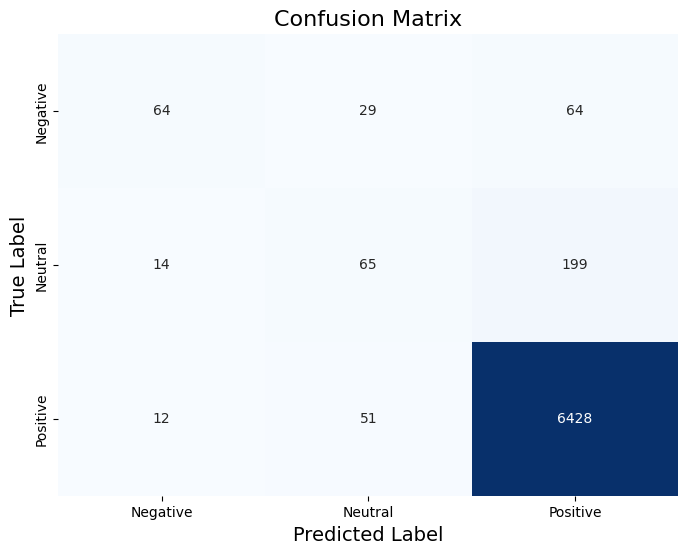

In [22]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

# Add labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Display the plot
plt.show()

In [24]:
""" import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Assuming predictions and labels are obtained from trainer.predict(val_dataset)
predictions = trainer.predict(val_dataset)
preds_prob = predictions.predictions  # Get probabilities (logits)
labels = predictions.label_ids  # True labels

# If your labels are multi-class, you need to binarize them for ROC
# For binary classification (e.g., Positive vs Negative), use the positive class probabilities
# In this case, let's assume class 2 is positive (adjust based on your classes)
preds_positive_prob = preds_prob[:, 2]  # Extract positive class probabilities

# Get false positive rate (FPR), true positive rate (TPR), and thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(labels, preds_positive_prob, pos_label=2)

# Calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='b', lw=2, label='RoBERTa: AUC = %0.2f' % roc_auc)

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RoBERTa Model')
plt.legend(loc='lower right')

# Show the plot
plt.show() """


" import matplotlib.pyplot as plt\nimport numpy as np\nfrom sklearn.metrics import roc_curve, auc\n\n# Assuming predictions and labels are obtained from trainer.predict(val_dataset)\npredictions = trainer.predict(val_dataset)\npreds_prob = predictions.predictions  # Get probabilities (logits)\nlabels = predictions.label_ids  # True labels\n\n# If your labels are multi-class, you need to binarize them for ROC\n# For binary classification (e.g., Positive vs Negative), use the positive class probabilities\n# In this case, let's assume class 2 is positive (adjust based on your classes)\npreds_positive_prob = preds_prob[:, 2]  # Extract positive class probabilities\n\n# Get false positive rate (FPR), true positive rate (TPR), and thresholds\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(labels, preds_positive_prob, pos_label=2)\n\n# Calculate AUC\nroc_auc = auc(false_positive_rate, true_positive_rate)\n\n# Plot the ROC curve\nplt.figure(figsize=(8, 6))\nplt.plot(false_posi

In [21]:
# Extract the 'text' from the val_dataset which is a Tensorfile now.
texts = val_texts  # This should be a list of the review texts used for validation

# Create a DataFrame with the texts, true labels, and predicted labels
df_results = pd.DataFrame({
    'Text': texts,
    'True Label': labels,
    'Predicted Label': preds
})

# Save the DataFrame as a CSV file for further analysis
df_results.to_csv("val_predictions.csv", index=False)

print("Predictions saved to 'val_predictions.csv'.")

Predictions saved to 'val_predictions.csv'.


In [25]:
# Example: Inference with new review
new_review = "This product is amazing, I love it!"
inputs = tokenizer(new_review, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Get model predictions
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"Sentiment: {label_mapping[predictions.item()]}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)